In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import tensorflow as tf
import numpy as np
import copy
from environment import MnistEnvironment, Environment
from spatial_transformer import transformer
import util

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from origin_model.mnist_solver import Network

In [3]:
mnist_cluttered = np.load('./data/mnist_sequence1_sample_5distortions5x5.npz')

X_train = mnist_cluttered['X_train']
y_train = mnist_cluttered['y_train']
X_valid = mnist_cluttered['X_valid']
y_valid = mnist_cluttered['y_valid']
X_test = mnist_cluttered['X_test']
y_test = mnist_cluttered['y_test']

x = tf.placeholder(tf.float32, [None, 1600])  # 40x40 image
keep_prob = tf.placeholder(tf.float32)

In [4]:
x_tensor = tf.reshape(x, [-1, 40, 40, 1])

- actor network
    - output: six real values

In [5]:
loc1 = tf.layers.dense(x, 20, activation=tf.nn.tanh)
loc1_drop = tf.nn.dropout(loc1, keep_prob)
loc2 = tf.layers.dense(loc1_drop, 6, activation=tf.nn.tanh)

In [6]:
loc2.shape

TensorShape([Dimension(None), Dimension(6)])

- transform the original image with affine matrix
    - 40x40 to 28x28

In [7]:
out_size = (28, 28)
h_trans = transformer(x_tensor, loc2, out_size)

In [8]:
h_trans.shape

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(None)])

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
img = X_train[123]
img = img.reshape([-1,1600])

- Random initialize된 $\theta$ 값을 대입하면,

In [11]:
theta, original, transformed = sess.run([loc2, x_tensor, h_trans], feed_dict={
       x: img, keep_prob: 1.0})
print(theta[0])
print(original.shape)
print(transformed.shape)

[ 0.4178349   0.55649936  0.12502383 -0.32465783 -0.1068315  -0.08057922]
(1, 40, 40, 1)
(1, 28, 28, 1)


In [12]:
original = np.squeeze(original)
transformed = np.squeeze(transformed)

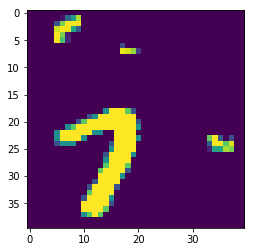

In [13]:
plt.imshow(original)

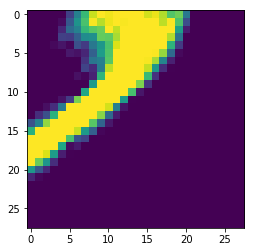

In [14]:
plt.imshow(transformed)

- 적절한 $\theta$ 값을 대입하면,

In [15]:
loc_new = np.array([0.5881693,  -0.139267,   -0.22556356, -0.31432164,  0.640401,    0.22847702])
loc_new = np.reshape(loc_new, [-1, 6])

In [16]:
original, transformed = sess.run([x_tensor, h_trans], feed_dict={
       x: img, loc2: loc_new, keep_prob: 1.0})

In [17]:
original_ = np.squeeze(original)
transformed_ = np.squeeze(transformed)

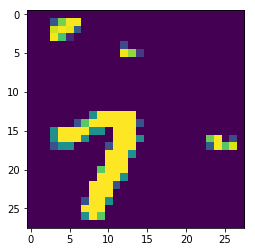

In [18]:
img_original = Image.fromarray(original_)
img_original = img_original.resize([28,28])
img_original = np.array(img_original)
plt.imshow(img_original)

In [19]:
model = Network(sess, phase='train') 

In [20]:
img_original = img_original.reshape([1,28,28,1])
prob_set = util.all_prob(model, img_original, mc=10)
unc_after = util.get_mutual_informations(prob_set)[0]
print(unc_after)

0.00030493728262470654


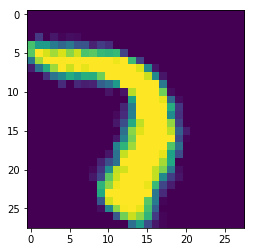

In [21]:
plt.imshow(transformed_)

In [22]:
prob_set = util.all_prob(model, transformed, mc=10)
unc_after = util.get_mutual_informations(prob_set)[0]
print(unc_after)

0.0005690123503843125
